In [ ]:
#%%harmonizome_api hide
import nbtemplate

# Imputing Knowledge about Gene and Protein Function with Machine Learning

In [202]:
# Imports
## Data processing
import pandas as pd
import numpy as np
## Machine Learning
import sklearn as sk
from sklearn import decomposition
from sklearn import ensemble
from sklearn import model_selection
from sklearn import pipeline
from sklearn import metrics
from sklearn import manifold
## Plotting
from matplotlib import pyplot as plt
## Harmonizome API
from harmonizome import Harmonizome
## Utility
import re
import json
from functools import reduce
from IPython.display import display

In [126]:
# Utility functions

## Early stopping function
def early_stopping(n_rounds, tol=0.001):
    def early_stopping_func(i, self, local):
        rounds = getattr(self, '__rounds', 0)
        last = getattr(self, '__last', None)
        current = self.train_score_[i]
        if last and current and abs(current - last) < tol:
            rounds += 1
            if rounds > n_rounds:
                return True
        else:
            rounds = 0
        setattr(self, '__last', current)
        setattr(self, '__rounds', rounds)
        return False
    return early_stopping_func

## Create custom "randfloat" that behaves like randint but for floats
from scipy.stats import uniform, randint
def randfloat(start, end):
    ''' Utility function for generating a float uniform distribution '''
    return uniform(start, end - start)

# reproducable random seed
rng = 2018

## Inputs

Given a target attribute of interest, we will use machine learning to predict genes that are strongly correlated with that target. Using the Harmonizome data query API, we download the dataset containing the target attribute as well as a number of well-populated Omics datasets for more genes and features and build a large sparse dataframe.

In [220]:
%%harmonizome_api
SectionField(
    title='ATTRIBUTE AND PREDICTION CLASS DATASET SELECTION',
    subtitle='Select the datasets to use for learning and classification.',
    group='DATASETS',
)

MultiChoiceField(
    name='attribute_datasets',
    label='Attribute Selection (place cursor inside the box to add more datasets)',
    hint='Databases to use for prediction',
    default=[
        'CCLE Cell Line Gene Expression Profiles',
        'ENCODE Transcription Factor Targets',
    ],
    choices=[
        'CCLE Cell Line Gene Expression Profiles',
        'ENCODE Transcription Factor Targets',
        'Allen Brain Atlas Adult Human Brain Tissue Gene Expression Profiles',
        'CHEA Transcription Factor Targets',
        'BioGPS Cell Line Gene Expression Profiles',
        'GTEx Tissue Gene Expression Profiles',
    ],
    group='DATASETS',
)

TargetClassSearchField(
    name='target_class',
    label='Class Selection',
    hint='Class you want to predict',
    default='integumentary system cancer (DOID:0060122 from DISEASES Text-mining Gene-Disease Assocation Evidence Scores)',
    hints=[
        'cancer',
        'lung',
        'heart',
        'tumor',
    ],
    group='DATASETS',
)

In [221]:
# Download attribute datasets from Harmonizome
df_attributes = list(Harmonizome.download_df(
    [dataset
     for dataset in attribute_datasets],
    ['gene_attribute_matrix.txt.gz'],
))
for name, df in zip(attribute_datasets, df_attributes):
    df.index.name = json.loads(df.index.name)[0]
    df.index = df.index.map(lambda s: json.loads(s)[0])
    print('%s shape:' % (name), df.shape)
    display(df.head())

# Assemble all attribute datasets
if len(df_attributes) > 1:
    # Obtain merged dataframe with omics and target data
    df = reduce(
        lambda a, b: pd.merge( # Merge two dataframes item by item
            a, # left
            b, # right
            # Items with the same left and right index are merged
            left_index=True,
            right_index=True,
            how='inner', # Drop any mis-matched index
        ),
        df_attributes,
    )
else:
    df = df_attributes[0]

X = df.applymap(lambda f: 1 if f==1 else 0)
print('Total Shape:', X.shape)
display(X.head())

CCLE Cell Line Gene Expression Profiles shape: (18025, 1037)


,"[""CHL1"", ""skin"", ""na""]","[""HMCB"", ""skin"", ""na""]","[""HS852T"", ""skin"", ""na""]","[""HS695T"", ""skin"", ""na""]","[""A101D"", ""skin"", ""na""]","[""HS294T"", ""skin"", ""na""]","[""SNU466"", ""central nervous system"", ""na""]","[""SKMEL31"", ""skin"", ""na""]","[""SKMEL24"", ""skin"", ""na""]","[""WM115"", ""skin"", ""na""]",...,"[""HEL9217"", ""haematopoietic and lymphoid tissue"", ""na""]","[""HEL"", ""haematopoietic and lymphoid tissue"", ""na""]","[""UT7"", ""haematopoietic and lymphoid tissue"", ""na""]","[""SET2"", ""haematopoietic and lymphoid tissue"", ""na""]","[""MOLM16"", ""haematopoietic and lymphoid tissue"", ""na""]","[""KU812"", ""haematopoietic and lymphoid tissue"", ""na""]","[""TF1"", ""haematopoietic and lymphoid tissue"", ""na""]","[""MEG01"", ""haematopoietic and lymphoid tissue"", ""na""]","[""KYO1"", ""haematopoietic and lymphoid tissue"", ""na""]","[""K562"", ""haematopoietic and lymphoid tissue"", ""na""]"
GeneSym,,,,,,,,,,,,,,,,,,,,,
FBN1,0.0,0.0,0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.0,0.0,0.0,0.0,0.0,0.0,-0.0,0.0,-0.0,-0.0
ITGBL1,-0.0,-0.0,0.0,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,-0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0
LRP1,-0.0,-0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0
LTBP2,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,0.0,-0.0,0.0,-0.0,...,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,-0.0,-0.0
PARVA,-0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0


ENCODE Transcription Factor Targets shape: (22819, 181)


,"[""ARID3A"", ""na"", ""1820""]","[""ATF1"", ""na"", ""466""]","[""ATF2"", ""na"", ""1386""]","[""ATF3"", ""na"", ""467""]","[""BACH1"", ""na"", ""571""]","[""BATF"", ""na"", ""10538""]","[""BCL11A"", ""na"", ""53335""]","[""BCL3"", ""na"", ""602""]","[""BCLAF1"", ""na"", ""9774""]","[""BDP1"", ""na"", ""55814""]",...,"[""ZC3H11A"", ""na"", ""9877""]","[""ZEB1"", ""na"", ""6935""]","[""ZKSCAN1"", ""na"", ""7586""]","[""ZMIZ1"", ""na"", ""57178""]","[""ZNF143"", ""na"", ""7702""]","[""ZNF217"", ""na"", ""7764""]","[""ZNF263"", ""na"", ""10127""]","[""ZNF274"", ""na"", ""10782""]","[""ZNF384"", ""na"", ""171017""]","[""ZZZ3"", ""na"", ""26009""]"
GeneSym,,,,,,,,,,,,,,,,,,,,,
A1BG,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A1BG-AS1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A1CF,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A2M,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A2ML1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0


Total Shape: (17480, 1218)


,"[""CHL1"", ""skin"", ""na""]","[""HMCB"", ""skin"", ""na""]","[""HS852T"", ""skin"", ""na""]","[""HS695T"", ""skin"", ""na""]","[""A101D"", ""skin"", ""na""]","[""HS294T"", ""skin"", ""na""]","[""SNU466"", ""central nervous system"", ""na""]","[""SKMEL31"", ""skin"", ""na""]","[""SKMEL24"", ""skin"", ""na""]","[""WM115"", ""skin"", ""na""]",...,"[""ZC3H11A"", ""na"", ""9877""]","[""ZEB1"", ""na"", ""6935""]","[""ZKSCAN1"", ""na"", ""7586""]","[""ZMIZ1"", ""na"", ""57178""]","[""ZNF143"", ""na"", ""7702""]","[""ZNF217"", ""na"", ""7764""]","[""ZNF263"", ""na"", ""10127""]","[""ZNF274"", ""na"", ""10782""]","[""ZNF384"", ""na"", ""171017""]","[""ZZZ3"", ""na"", ""26009""]"
GeneSym,,,,,,,,,,,,,,,,,,,,,
FBN1,0,0,0,0,0,0,0,0,0,0,...,0,1,1,0,1,0,1,0,1,0
ITGBL1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
LRP1,0,0,0,0,0,0,1,0,0,0,...,1,0,0,1,1,0,1,0,1,0
LTBP2,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,0,0,0,1,0
PARVA,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0


In [222]:
# Separate target attribute and dataset
class_name, class_type, class_dataset = re.match(
    r'^(.+) \((.+) from (.+)\)$',
    target_class,
).groups()
target_class_col = class_name

# Download class datasets from Harmonizome
df_class = list(Harmonizome.download_df(
    [class_dataset],
    ['gene_attribute_matrix.txt.gz'],
))[0]
df_class.columns = df_class.columns.map(lambda s: json.loads(s)[0])
df_class.index.name = json.loads(df_class.index.name)[0]
df_class.index = df_class.index.map(lambda s: json.loads(s)[0])
print('%s shape:' % (class_dataset), df_class.shape)
display(df_class.head())

# Collect genes of interest
target_genes = df_class[df_class[target_class_col] == 1].index
print('Number of Target Genes:', len(target_genes))

DISEASES Text-mining Gene-Disease Assocation Evidence Scores shape: (15309, 4628)


,integumentary system cancer,skin cancer,skin carcinoma,basal cell carcinoma,keratoacanthoma,skin squamous cell carcinoma,actinic keratosis,seborrheic keratosis,verrucous carcinoma,infiltrative basal cell carcinoma,...,alternating exotropia,masters-allen syndrome,charcot-marie-tooth disease type 4,anal margin carcinoma,poland syndrome,cortical deafness,form agnosia,breast lipoma,queensland tick typhus,fatal infantile encephalocardiomyopathy
GeneSym,,,,,,,,,,,,,,,,,,,,,
LRRTM4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ZNF507,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
LRFN4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
IMPA2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
FAM174B,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Number of Target Genes: 904


In [223]:
# Create final target array
y = np.in1d(X.index, target_genes).astype(np.int8)
print('Known Target Genes: %d (%0.3f %%)' % (y.sum(), 100*y.sum()/len(y)))

# Output data shapes
print('Input shape:', X.shape)
print('Target shape:', y.shape)

Known Target Genes: 824 (4.714 %)
Input shape: (17480, 1218)
Target shape: (17480,)


## Dimensionality Reduction

We perform dimensionality reduction.

In [224]:
%%harmonizome_api

SectionField(
    title='SETTINGS',
    subtitle='From here you can select the various available Machine Learning algorithms, their unique settings, and the methods to use to evaluate the classifier.',
    group='SETTINGS',
)

ChoiceField(
    name='clf_dimensionality_reduction',
    label='Dimensionality Reduction Algorithm',
    default='PCA',
    choices={
        'PCA': 'sk.decomposition.PCA(n_components=64)',
        'TruncatedSVD': 'sk.decomposition.TruncatedSVD(n_components=64)',
    },
    raw=True,
    group='SETTINGS'
)

In [225]:
X_reduced = clf_dimensionality_reduction.fit_transform(X.values)
print('Explained variance:', np.sum(clf_dimensionality_reduction.explained_variance_))

Explained variance: 26.330936813027748


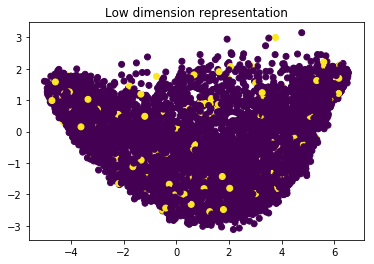

In [226]:
# Perform TSNE for low dimensional visualization

#tsne = sk.manifold.TSNE(n_components=2, random_state=rng)
#X_transformed_tsne = tsne.fit_transform(X_reduced, y)

# Plot results of TSNE
plt.title('Low dimension representation')
#plt.scatter(
#    X_transformed_tsne[:, 0],
#    X_transformed_tsne[:, 1],
#    c=y,
#)
# Substitute for Demo
plt.scatter(
    X_reduced[:, 0],
    X_reduced[:, 1],
    c=y,
)
plt.show()

## Algorithm

We will perform the analysis based on the selections made here.

In [227]:
%%harmonizome_api

ChoiceField(
    name='algorithm',
    label='Machine Learning Algorithm',
    default='RandomForestClassifier',
    choices={
        'GradientBoostingClassifier': 'sk.ensemble.GradientBoostingClassifier()',
        'RandomForestClassifier': 'sk.ensemble.RandomForestClassifier()',
    },
    raw=True,
    group='SETTINGS'
)

ChoiceField(
    name='hyper_param_search',
    label='Hyper Parameter Search Type',
    default='RandomizedSearchCV',
    choices={
        'RandomizedSearchCV': 'sk.model_selection.RandomizedSearchCV',
        'GridSearchCV': 'sk.model_selection.GridSearchCV',
    },
    raw=True,
    group='SETTINGS'
)

IntField(
    name='cross_validation_n_folds',
    label='Cross-Validated Folds',
    default=3,
    min=2,
    max=10,
    group='SETTINGS'
)

ChoiceField(
    name='primary_metric',
    label='Primary Evaluation Metric',
    default='roc_auc',
    choices=[
        'explained_variance',
        'r2',
        'neg_median_absolute_error',
        'neg_mean_absolute_error',
        'neg_mean_squared_error',
        'neg_mean_squared_log_error',
        'median_absolute_error',
        'mean_absolute_error',
        'mean_squared_error',
        'accuracy',
        'roc_auc',
        'average_precision',
        'log_loss',
        'neg_log_loss',
        'adjusted_rand_score',
        'homogeneity_score',
        'completeness_score',
        'v_measure_score',
        'mutual_info_score',
        'adjusted_mutual_info_score',
        'normalized_mutual_info_score',
        'fowlkes_mallows_score',
        'precision',
        'precision_macro',
        'precision_micro',
        'precision_samples',
        'precision_weighted',
        'recall',
        'recall_macro',
        'recall_micro',
        'recall_samples',
        'recall_weighted',
        'f1',
        'f1_macro',
        'f1_micro',
        'f1_samples',
        'f1_weighted'
    ],
    group='SETTINGS'
)

MultiChoiceField(
    name='evaluation_metrics',
    label='Evaluation Metrics',
    default=[],
    choices=[
        'explained_variance',
        'r2',
        'neg_median_absolute_error',
        'neg_mean_absolute_error',
        'neg_mean_squared_error',
        'neg_mean_squared_log_error',
        'median_absolute_error',
        'mean_absolute_error',
        'mean_squared_error',
        'accuracy',
        'roc_auc',
        'average_precision',
        'log_loss',
        'neg_log_loss',
        'adjusted_rand_score',
        'homogeneity_score',
        'completeness_score',
        'v_measure_score',
        'mutual_info_score',
        'adjusted_mutual_info_score',
        'normalized_mutual_info_score',
        'fowlkes_mallows_score',
        'precision',
        'precision_macro',
        'precision_micro',
        'precision_samples',
        'precision_weighted',
        'recall',
        'recall_macro',
        'recall_micro',
        'recall_samples',
        'recall_weighted',
        'f1',
        'f1_macro',
        'f1_micro',
        'f1_samples',
        'f1_weighted'
    ],
    group='SETTINGS',
)

In [217]:
%%harmonizome_api
param_grid = {
    'reduce_dim__n_components': randint(2, 1024),
{% if algorithm == 'GradientBoostingClassifier' %}
    'clf__loss': ['deviance', 'exponential'],
    'clf__learning_rate': randfloat(0.001, 1.),
    'clf__subsample': randfloat(0.01, 1.),
{% elif algorithm == 'RandomForestClassifier' %}
    'clf__oob_score': [True],
    'clf__criterion': ['gini', 'entropy'],
{% endif %}
    'clf__n_estimators': randint(10, 200),
    'clf__max_depth': randint(20, 50),
    'clf__max_features': ['sqrt', 'log2', None],
    'clf__min_impurity_decrease': randfloat(0., 0.2),
    'clf__min_weight_fraction_leaf': randfloat(0., 0.5),
}

SyntaxError: invalid syntax (<string>, line 3)

In [210]:
# TODO: make selectable
cv_algorithm = sk.model_selection.StratifiedKFold
n_iter = 1

In [216]:
pipe = sk.pipeline.Pipeline([
    # Reduce dimensionality by applying TruncatedSVD
    ('reduce_dim', dimensionality_reduction_algorithm),
    # Classify with gradient boosting
    ('clf', algorithm),
])

cv = cv_algorithm(
    n_splits=cross_validation_n_folds,
    shuffle=True,
    random_state=rng,
)

# Fit parameters
fit_params = {
#!  {% if algorithm == 'GradientBoostingClassifier' %}
    'clf__monitor': early_stopping(5),
#!  {% endif %}
}

# Scoring parameters
scoring_params = {k: v
                  for k,v in metrics.scorer.SCORERS.items()
                  if k == primary_metric or k in evaluation_metrics}

# Params to pass to search
search_params = {
    'cv': cv,
    'refit': primary_metric,
    'verbose': 10,
    'random_state': rng,
    'scoring': {k: v
                for k,v in scoring_params.items()
                if k == primary_metric or k in evaluation_metrics},
    'return_train_score': True,
    'n_iter': n_iter,
}

search = hyper_param_search(
    pipe,
    param_grid,
    **search_params,
)

This will take a long time as we are evaluating n_iter different models n_splits different times each computing all the metrics on `product(X.shape)` data points--not to mention the size of each model dictated by the range of parameters specified in the params dict.

In [ ]:
# Evaluate pipeline
search.fit(X.values, y, **fit_params)

In [ ]:
# Display training results
if n_iter > 1:
    for metric in [primary_metric]+evaluation_metrics:
        df_met = pd.DataFrame.from_dict({
            'mean_test_%s' % (metric): search.cv_results_['mean_test_%s' % (metric)],
            'mean_train_%s' % (metric): search.cv_results_['mean_train_%s' % (metric)],
        }).sort_values('mean_test_%s' % (metric), ascending=False)
        df_met.plot(use_index=False)
        plt.title('Mean %s' % (metric))
        plt.show()

In [ ]:
# Calculate final ROC curve
y_probas = search.predict_proba(X.values)
fpr, tpr, _ = sk.metrics.roc_curve(y, y_probas[:, 1])
score = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, label='Final (AUC=%.3f)' % (score))
# Annotate chart
plt.plot([0, 1], [0, 1], '--', label='Luck')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.legend(loc='lower right')
plt.show()

In [ ]:
cm = metrics.confusion_matrix(y, search.predict(X.values))
display(cm)
print('\n',
    'True labels predicted to be true:', cm[0,0], '\n',
    'True labels predicted to be false:', cm[0,1], '\n',
    'False labels predicted to be true:', cm[1,0], '\n',
    'False labels predicted to be false:', cm[1,1])

In [ ]:
# Obtain prediction results
y_preds = search.predict(X)
y_probas = search.predict_proba(X)[:, 1]
results = pd.DataFrame(np.array([
    y,
    y_preds,
    y_probas,
]).T, columns=[
    'Known',
    'Predicted',
    'Prediction Probability',
], index=X.index)
results[(results['Prediction Probability'] > 0.5)]